# Isotropic Scaling Experiment

## Synopsis

In this experiment, I will be looking at how the isotropic scaling effects the HSIC score for the HSIC and KA algorithms. In theory, because we are trying to find one parameter shared between the two kernel functions, there should be problems when the scale of one distribution is larger than another. It's a drawback of the method and it motivates the need to use two different parameters for the distributions.

## Code

In [107]:
import sys, os
# Insert path to model directory,.
cwd = os.getcwd()
path = f"{cwd}/../../src"
sys.path.insert(0, path)

import warnings
import tqdm
import random
import pandas as pd
import numpy as np
import argparse
from sklearn.utils import check_random_state

# toy datasets
from data.toy import generate_dependence_data, generate_isotropic_data

# Kernel Dependency measure
from models.train_models import get_gamma_init
from models.train_models import get_hsic
from models.kernel import estimate_sigma, sigma_to_gamma, gamma_to_sigma, get_param_grid
from models.ite_algorithms import run_rbig_models
from sklearn.preprocessing import StandardScaler

# Plotting
from visualization.distribution import plot_scorer
from visualization.scaling import plot_scorer_scale, plot_scorer_scale_norm


# experiment helpers
from tqdm import tqdm

# Plotting Procedures
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# plt.style.use(['fivethirtyeight', 'seaborn-poster'])
warnings.filterwarnings('ignore') # get rid of annoying warnings
%matplotlib inline


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
plt.style.available

['seaborn-dark-palette',
 'classic',
 'ggplot',
 'seaborn-dark',
 'seaborn-pastel',
 'seaborn-bright',
 'seaborn-deep',
 'tableau-colorblind10',
 'seaborn-talk',
 'fast',
 'seaborn-ticks',
 'seaborn-white',
 'bmh',
 'fivethirtyeight',
 'seaborn-muted',
 '_classic_test',
 'grayscale',
 'seaborn-darkgrid',
 'seaborn-poster',
 'seaborn',
 'seaborn-whitegrid',
 'dark_background',
 'seaborn-paper',
 'seaborn-colorblind',
 'seaborn-notebook',
 'Solarize_Light2']

## Demo

### Case I - Unscaled, Unnormalized

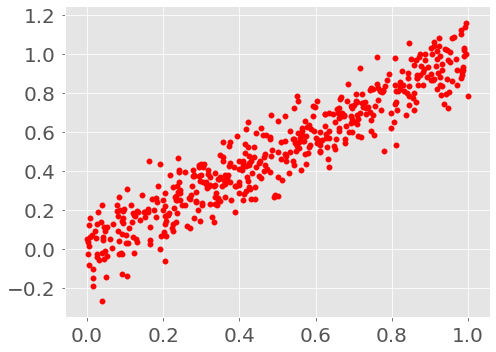

In [11]:
# data params
dataset = 'line'
num_points = 500
seed = 123
noise_x = 0.1
noise_y = 0.1
alpha = 1.0
beta = 1.0
scale = 1.0

# get dataset
X, Y = generate_dependence_data(
    dataset=dataset,
    num_points=num_points,
    seed=seed,
    noise_x=noise_x,
    noise_y=noise_y,
    alpha=alpha,
    beta=beta
)

fig, ax = plt.subplots(nrows=1, figsize=(7, 5))

ax.scatter(X, Y, color='red')
# plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.show()

save_path = f'{cwd}/../../results/figures/scaling_experiment/demo/'
fig.savefig(f"{save_path}demo_{dataset}_s0_n0.png")

### Case II - Unscaled, Normalized

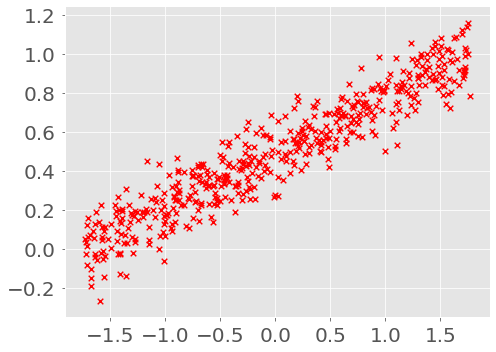

In [12]:
# data params
dataset = 'line'
num_points = 500
seed = 123
noise_x = 0.1
noise_y = 0.1
alpha = 1.0
beta = 1.0
scale = 1.0

# get dataset
X, Y = generate_dependence_data(
    dataset=dataset,
    num_points=num_points,
    seed=seed,
    noise_x=noise_x,
    noise_y=noise_y,
    alpha=alpha,
    beta=beta
)

# Normalize
X = StandardScaler().fit_transform(X)

fig, ax = plt.subplots(nrows=1, figsize=(7, 5))

ax.scatter(X, Y, marker='x', color='red')
# plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.show()

save_path = f'{cwd}/../../results/figures/scaling_experiment/demo/'
fig.savefig(f"{save_path}demo_{dataset}_s0_n1.png")

### Case III - Scaled, Unnormalized

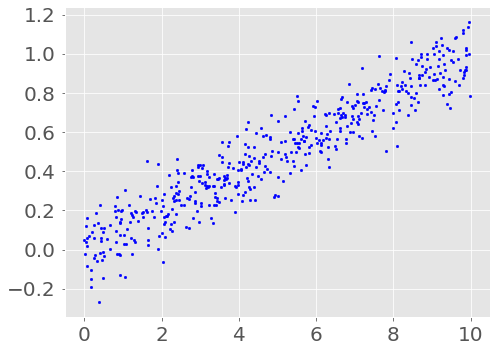

In [15]:
# data params
dataset = 'line'
num_points = 500
seed = 123
noise_x = 0.1
noise_y = 0.1
alpha = 10.0
beta = 1.0

# get dataset
X, Y = generate_dependence_data(
    dataset=dataset,
    num_points=num_points,
    seed=seed,
    noise_x=noise_x,
    noise_y=noise_y,
    alpha=alpha,
    beta=beta
)

# Normalize
# X = StandardScaler().fit_transform(X)

fig, ax = plt.subplots(nrows=1, figsize=(7, 5))

ax.scatter(X, Y, marker='.', color='blue')
# plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.show()

save_path = f'{cwd}/../../results/figures/scaling_experiment/demo/'
fig.savefig(f"{save_path}demo_{dataset}_s1_n0.png")

### Case IV - Scaled, Normalized

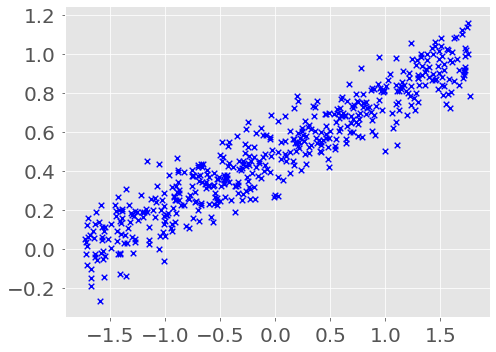

In [16]:
# data params
dataset = 'line'
num_points = 500
seed = 123
noise_x = 0.1
noise_y = 0.1
alpha = 10.0
beta = 1.0
scale = 10.0

# get dataset
X, Y = generate_dependence_data(
    dataset=dataset,
    num_points=num_points,
    seed=seed,
    noise_x=noise_x,
    noise_y=noise_y,
    alpha=alpha,
    beta=beta
)

# Normalize
X = StandardScaler().fit_transform(X)

fig, ax = plt.subplots(nrows=1, figsize=(7, 5))

ax.scatter(X, Y, marker='x', color='blue')
# plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.show()

save_path = f'{cwd}/../../results/figures/scaling_experiment/demo/'
fig.savefig(f"{save_path}demo_{dataset}_s1_n0.png")

## Prelim. Experiment - Different Scorers and Initializers

In this preliminary experiment, we are going to look at different scores and intializers and see how they react to a scaling of 10.

In [17]:
from typing import Tuple, Type

def get_gamma_name(gamma_method: Tuple[str,str,str])-> str:
    if gamma_method[1] is None and gamma_method[2] is None:
        gamma_name = gamma_method[0]
    elif gamma_method[1] is not None and gamma_method[2] is None:
        gamma_name = f"{gamma_method[0]}_p{gamma_method[1]}"
    elif gamma_method[1] is None and gamma_method[2] is not None:
        gamma_name = f"{gamma_method[0]}_s{gamma_method[2]}"
    elif gamma_method[1] is not None and gamma_method[2] is not None:
        gamma_name = f"{gamma_method[0]}_s{gamma_method[1]}_s{gamma_method[2]}"
    else:
        raise ValueError('Unrecognized Combination...')
    return gamma_name

In [126]:
def run_scale_experiment(exp_params: Type[ExpArgs], scale: int=1.0, )-> pd.DataFrame:
    
    # =====================
    # Dependence Data
    # =====================
    
    
    # get dataset
    X, Y = generate_dependence_data(
        dataset=dataset,
        num_points=num_points,
        seed=seed,
        noise_x=noise_x,
        noise_y=noise_y
    )
    
    # ========================
    # experimental parameters
    # ========================
    
    # HSIC methods
    scorers = ['hsic', 'tka', 'ctka']  
    normalizers = [True, False]
    
    # Different Gamma value intializers
    gamma_methods = [
#         ('silverman',None, None),
#         ('scott', None, None),
        ('median', 0.2, None),
        ('median', 0.4, None),
        ('median', None, None),
        ('median', 0.6, None),
        ('median', 0.8, None),
#         ('median', None, 0.01),
#         ('median', None, 0.1),
#         ('median', None, 10),
#         ('median', None, 100),
    ]

    # results dataframe
    results_df = pd.DataFrame()


    # run experiment

    for imethod in gamma_methods:
        for iscorer in scorers:
            for inormalize in normalizers:

                # generate isotropic data exp
                X, Y = generate_isotropic_data(
                    dataset=exp_params.dataset,
                    num_points=exp_params.num_points,
                    seed=exp_params.seed,
                    scale=scale,
                )

                if inormalize:
                    X = StandardScaler().fit_transform(X)
                    Y = StandardScaler().fit_transform(Y)
                
                # get mutual information
                mi, _ = run_rbig_models(X, Y, measure='mi', verbose=None)
                
                # initialize gamma
                gamma_init = get_gamma_init(X, Y, imethod[0], imethod[1], imethod[2])

                # get hsic_value
                hsic_value = get_hsic(X, Y, iscorer, gamma_init, maximum=False)

                # append results to dataframe
                gamma_name = get_gamma_name(imethod)

                results_df = results_df.append({
                    'normalized': inormalize,
                    'scaled': True if scale != 1.0 else False,
                    'dataset': exp_params.dataset,
                    'scale': scale,
                    'scorer': iscorer,
                    'gamma_method': gamma_name,
                    'gamma_init': gamma_init,
                    'hsic_value': hsic_value,
                    "mi": mi,
                }, ignore_index=True)
    
    return results_df

#### BaseLine Performance - No Scale

In [109]:
# experimental params
class ExpArgs:
    dataset = 'line'
    num_points = 500
    seed = 123
    

In [110]:
scale = 1.0

results_df = run_scale_experiment(ExpArgs, scale)

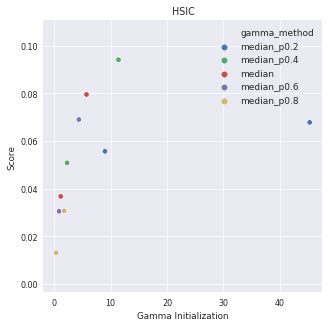

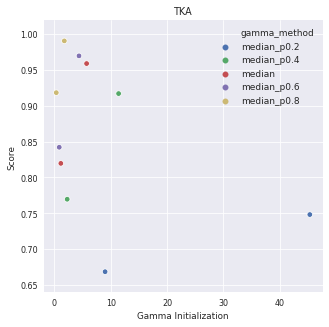

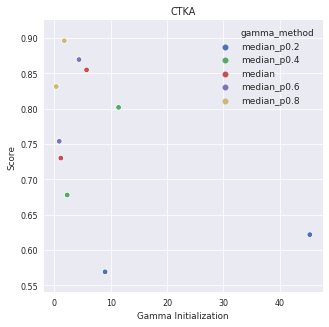

In [78]:
plot_scorer(results_df, 'hsic')
plot_scorer(results_df, 'tka')
plot_scorer(results_df, 'ctka')

Except for a few outliers in each of the methods, most of the initializations seem to be clustered around the same value for each of the methods. The HSIC seems to have the most spread for the points. But the KA and CKA methods have more clustered points.

#### W. Scaling Parameter - $\alpha=10$

Now let's see if we apply a modest amount of scaling to our dataset. 

**Note**: we are applying the scaling to $X$ after generating the dependence dataset. So:

1. Generate Data: $X,Y$.
2. Apply scaling to $X$ only: $\alpha X, Y$.

In [79]:
scale = 10.0

results_df = run_scale_experiment(ExpArgs, scale)

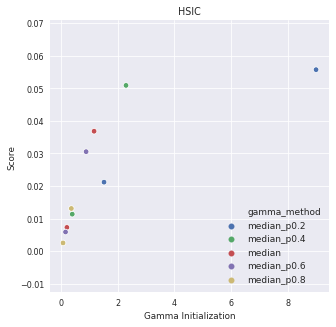

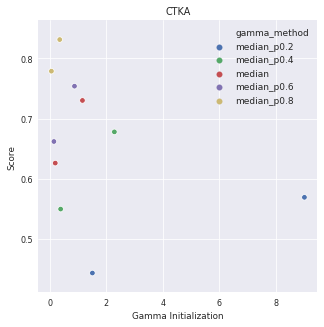

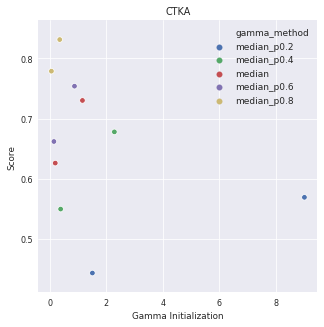

In [80]:
plot_scorer(results_df, 'hsic')
plot_scorer(results_df, 'ctka')
plot_scorer(results_df, 'ctka')

So for the most part, we see that each of the methods have a significantly different score depending upon the scale that is apply to $X$. 

## Experiment: Different Scales Applied to Line Dataset

In [136]:
def run_mscales_experiment(exp_args: Type[ExpArgs])-> pd.DataFrame:
    
    exp_df = pd.DataFrame()
    with tqdm(ExpArgs.scale_params) as pbar:
        for iscale in pbar:

            # run experiment for 1 scale parameter
            results_df = run_scale_experiment(exp_args, iscale)

            # append results to experiment df
            exp_df = exp_df.append(results_df, ignore_index=True)

            # update progress bar
            postfix = dict(
                Scale=f"{iscale:.3f}",
            )
            pbar.set_postfix(postfix)
    return exp_df

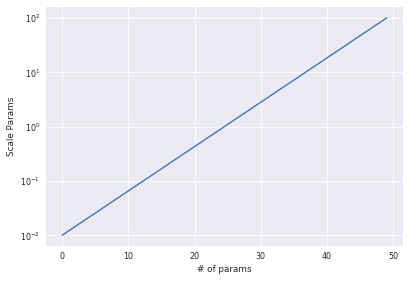

In [137]:
plt.figure()
plt.plot(np.logspace(-2,2, 50))
plt.yscale('log')
plt.ylabel('Scale Params')
plt.xlabel('# of params')
plt.show()

In [138]:
np.logspace(-2,2,11)

array([1.00000000e-02, 2.51188643e-02, 6.30957344e-02, 1.58489319e-01,
       3.98107171e-01, 1.00000000e+00, 2.51188643e+00, 6.30957344e+00,
       1.58489319e+01, 3.98107171e+01, 1.00000000e+02])

In [139]:
# fixed experimental params
class ExpArgs:
    dataset = 'line'
    num_points = 500
    seed = 123
    scale_params = np.logspace(-2,2,11)

# Exploratory experiment params

# run experiment
exp_df_v0 = run_mscales_experiment(ExpArgs)


# save data

100%|██████████| 11/11 [02:42<00:00, 14.74s/it, Scale=100.000]


In [85]:
# results_path = '/home/emmanuel/projects/2019_hsic_align/data/results/scaling/'
# results_name = 'scaling_v1.csv'
# # results_df.to_csv(results_path + results_name)

In [86]:
# results_df = pd.read_csv(results_path + results_name)

In [134]:
exp_df_v0[exp_df_v0['scaled'] == 1.0]

NameError: name 'exp_df_v0' is not defined

In [133]:
plot_scorer_scale_norm(
    exp_df_v0, 
    'hsic', 
    'line', 
    style=['seaborn', 'seaborn-paper'], 
    log_scale=False, 
    save=False, 
    title='', 
    plot_legend=False,
)
# plot_scorer_scale_norm(
#     exp_df_v0, 
#     'tka', 
#     'line', 
#     style=['seaborn', 'seaborn-paper'], 
#     log_scale=True, 
#     save=False, 
#     title='', 
#     plot_legend=False,
# )

plot_scorer_scale_norm(
    exp_df_v0, 
    'ctka', 
    'line', 
    style=['seaborn', 'seaborn-paper'], 
    log_scale=True, 
    save=False, 
    title='', 
    plot_legend=False,
)
# plot_scorer_scale(exp_df, 'tka', 'line', style=['seaborn', 'seaborn-paper'], log_scale=True, save=True, title='', plot_legend=False)
# plot_scorer_scale(exp_df, 'ctka', 'line', style=['seaborn', 'seaborn-paper'], log_scale=True, save=True, title='', plot_legend=True)

NameError: name 'exp_df_v0' is not defined

## Experiment: Different Scales Applied to different Datasets

In [119]:
from typing import List

def run_mscales_experiment(exp_args: Type[ExpArgs])-> pd.DataFrame:
    
    exp_df = pd.DataFrame()
    with tqdm(ExpArgs.scale_params) as pbar:
        for iscale in pbar:
            
            for idataset in ExpArgs.dataset_params:
                
                exp_args.dataset = idataset
                
                # run experiment for 1 scale parameter
                results_df = run_scale_experiment(exp_args, iscale)

                # append results to experiment df
                exp_df = exp_df.append(results_df, ignore_index=True)

                # update progress bar
                postfix = dict(
                    Dataset=f"{exp_args.dataset}",
                    Scale=f"{iscale:.3f}",
                )
                pbar.set_postfix(postfix)
    return exp_df

In [120]:
# fixed experimental params
class ExpArgs:
    dataset = 'line'
    num_points = 500
    seed = 123
    # Exploratory experiment params
    scale_params = np.logspace(-2,2, 11)
    dataset_params = ['line', 'sine', 'circle', 'random']




# run experiment
exp_df = run_mscales_experiment(ExpArgs)


# save data

100%|██████████| 11/11 [11:07<00:00, 60.70s/it, Dataset=random, Scale=100.000]


#### Dataset - Sine

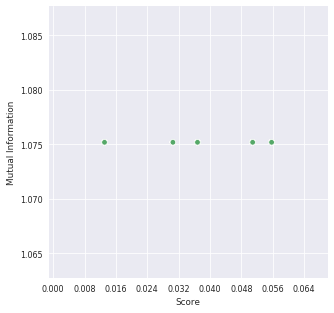

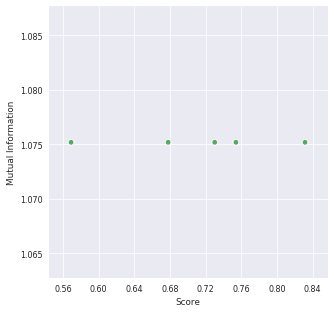

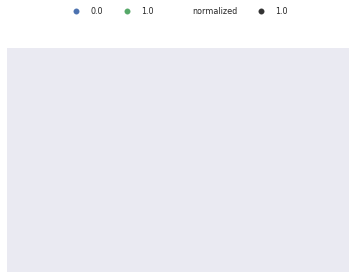

In [132]:
plot_scorer_scale_norm(
    exp_df[exp_df['normalized']== True], 
    'hsic', 
    'line', 
    style=['seaborn', 'seaborn-paper'], 
    log_scale=True, 
    save=True, 
    title='', 
    plot_legend=False,
)
# plot_scorer_scale_norm(
#     exp_df, 
#     'tka', 
#     'line', 
#     style=['seaborn', 'seaborn-paper'], 
#     log_scale=True, 
#     save=True, 
#     title='', 
#     plot_legend=False,
# )
plot_scorer_scale_norm(
    exp_df[exp_df['normalized']== True], 
    'ctka', 
    'line', 
    style=['seaborn', 'seaborn-paper'], 
    log_scale=True, 
    save=True, 
    title='', 
    plot_legend=True,
)

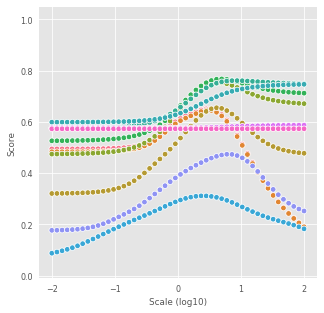

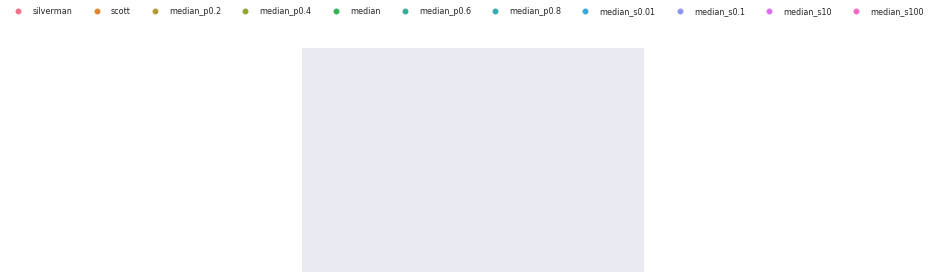

In [278]:
# plot_scorer_scale(exp_df, 'hsic', 'sine', style=['seaborn', 'seaborn-paper'], log_scale=True, save=True, title='', plot_legend=False)
# plot_scorer_scale(exp_df, 'tka', 'sine', style=['seaborn', 'seaborn-paper'], log_scale=True, save=True, title='', plot_legend=False)
plot_scorer_scale(exp_df, 'ctka', 'sine', style=['seaborn', 'seaborn-paper'], log_scale=True, save=True, title='', plot_legend=True)

#### Dataset - Circle

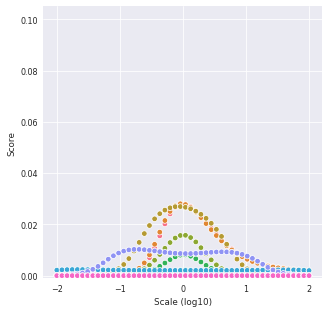

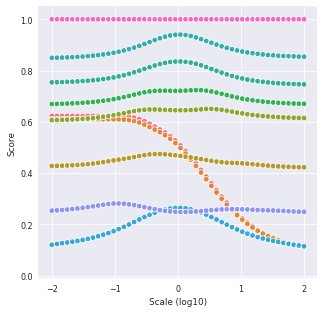

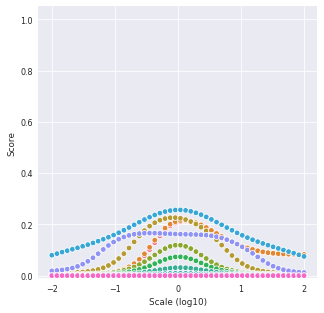

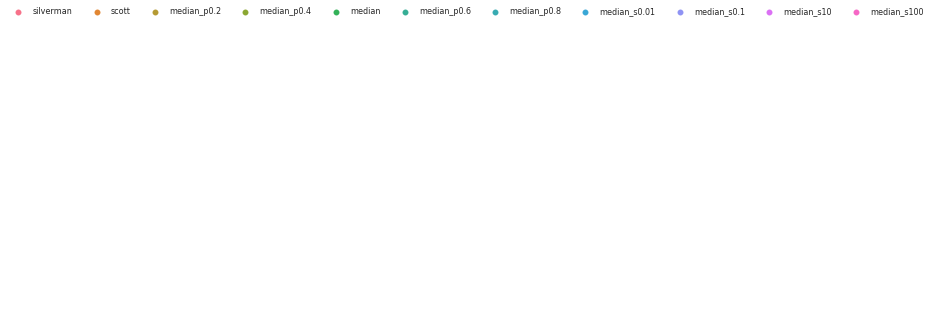

In [269]:
plot_scorer_scale(exp_df, 'hsic', 'circle', style=['seaborn', 'seaborn-paper'], log_scale=True, save=True, title='', plot_legend=False)
plot_scorer_scale(exp_df, 'tka', 'circle', style=['seaborn', 'seaborn-paper'], log_scale=True, save=True, title='', plot_legend=False)
plot_scorer_scale(exp_df, 'ctka', 'circle', style=['seaborn', 'seaborn-paper'], log_scale=True, save=True, title='', plot_legend=True)

#### Dataset - Random

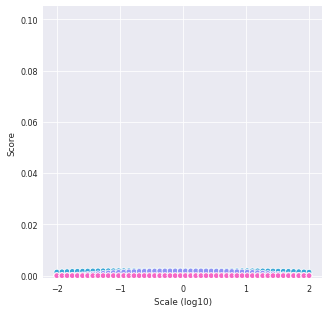

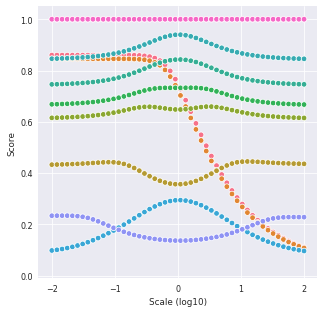

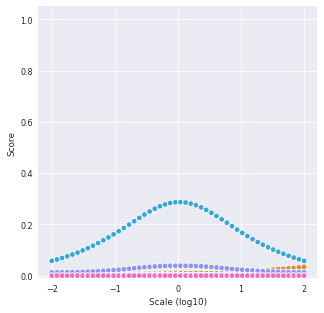

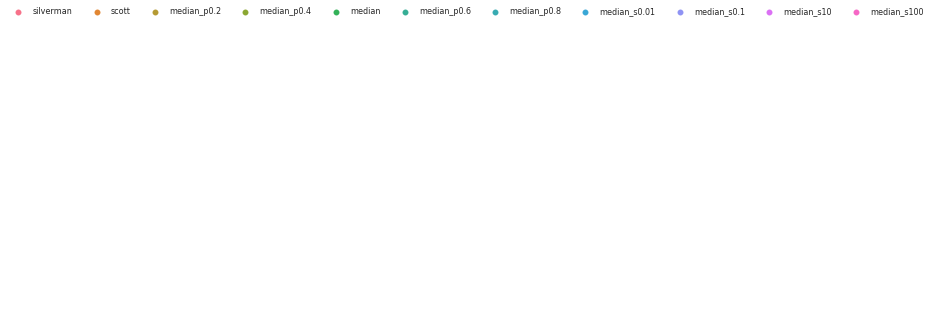

In [271]:
plot_scorer_scale(exp_df, 'hsic', 'random', style=['seaborn', 'seaborn-paper'], log_scale=True, save=True, title='', plot_legend=False)
plot_scorer_scale(exp_df, 'tka', 'random', style=['seaborn', 'seaborn-paper'], log_scale=True, save=True, title='', plot_legend=False)
plot_scorer_scale(exp_df, 'ctka', 'random', style=['seaborn', 'seaborn-paper'], log_scale=True, save=True, title='', plot_legend=True)